<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Static-parameter" data-toc-modified-id="Static-parameter-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Static parameter</a></span></li><li><span><a href="#Gate-parameters" data-toc-modified-id="Gate-parameters-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gate parameters</a></span></li><li><span><a href="#Gate-optimization" data-toc-modified-id="Gate-optimization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Gate optimization</a></span></li><li><span><a href="#Sweep-parameters" data-toc-modified-id="Sweep-parameters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Sweep parameters</a></span></li><li><span><a href="#Check-leakage" data-toc-modified-id="Check-leakage-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Check leakage</a></span></li><li><span><a href="#Plot-for-paper" data-toc-modified-id="Plot-for-paper-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plot for paper</a></span></li></ul></div>

# Import

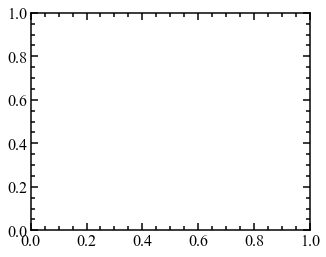

In [1]:
import sys
sys.dont_write_bytecode = True
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate
import qutip as qt
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import qchard_fluxonium as fluxonium
from Fluxonium_hamiltonians import qchard_coupobj as coupobj
from Fluxonium_hamiltonians import qchard_evolgates as gates
from Fluxonium_hamiltonians import qchard_resonator as resonator
from Fluxonium_hamiltonians import qchard_rotope as op
import plotting_settings
from scipy.optimize import minimize
from qutip import*
from datetime import datetime
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/HCF paper/'

# Static parameter

In [147]:
# Parameters from notebook 2e. Multipath coupling. 
#Energies are in GHz

E_L1 = 0.5
E_C1 = 1.0
E_J1 = 4

E_L2 = 0.55
E_C2 = 1.0
E_J2 = 4

J_L = 0.002
J_C = 0.0115
phi_ext_A = np.pi
phi_ext_B = np.pi

method = 'propagator'

# Hilbert space.
nlev_q = 2

# Indices of the computational space.
comp_space = ['00', '01', '10', '11']
interaction = 'on'

# Instantiate objects
qubitA = fluxonium.Fluxonium(
    E_L=E_L1, E_C=E_C1, E_J=E_J1, nlev=nlev_q, phi_ext = phi_ext_A)
qubitB = fluxonium.Fluxonium(
    E_L=E_L2, E_C=E_C2, E_J=E_J2, nlev=nlev_q, phi_ext = phi_ext_B)
system = coupobj.CoupledObjects(qubitA, qubitB,
                                [qubitA, qubitB, J_L, 'flux'],
                                [qubitA, qubitB, J_C, 'charge'])

In [148]:
#Define operators
IZ = tensor(qeye(nlev_q), op.sigz(nlev_q))
ZI = tensor(op.sigz(nlev_q), qeye(nlev_q))
XI = tensor(op.sigx(nlev_q), qeye(nlev_q))
IX = tensor(qeye(nlev_q), op.sigx(nlev_q))
YI = tensor(op.sigy(nlev_q), qeye(nlev_q))
IY = tensor(qeye(nlev_q), op.sigy(nlev_q))
state_00 = system.eigvec('00')
state_10 = system.eigvec('10')
state_01 = system.eigvec('01')
state_11 = system.eigvec('11')
sup_state0 = (state_00 + state_01)/np.sqrt(2)
sup_state1 = (state_10 + state_11)/np.sqrt(2)

# Gate parameters

In [149]:
## Here, check the drive amplitude wrt qubit A
# Calculate the drive frequency.
transition_to_drive = ('00', '10', '01')
level1, level2, level3 = transition_to_drive[0], transition_to_drive[1], transition_to_drive[2]
delta_omega_d = 0.05
omega_d = abs(system.freq(level1, level3)) + delta_omega_d

# Pulse shape.
shape = 'cosflattop'  # 'gauss', 'cos' for 1-cos, or 'square'
sigma = 0.25  # sigma in units of T_gate for shape=='gauss'
drag = False
drag_coeff = 0.2

T_gate = 200
T_rise = T_gate/3.0
# Calculate the drive amplitude.
drive_amplitude1 = 45     # MHz
drive_amplitude2 = 20  # MHz

drive_amplitude1 = drive_amplitude1*1e-3*2*np.pi
drive_amplitude2 = drive_amplitude2*1e-3*2*np.pi

matr_el1 = np.abs(system.phi_ij(qubitA, level1, level2))
matr_el2 = np.abs(system.phi_ij(qubitB, level1, level3))       
epsilon1 = drive_amplitude1 / abs(matr_el1)
epsilon2 = drive_amplitude2 / abs(matr_el2)

t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)

# The time-independent operator part of the drive term.
H_drive = epsilon1*system.phi(0) + epsilon2*system.phi(1)
U_t = gates.evolution_operator_microwave_nonorm(system.H(), H_drive, t_points=t_points,T_gate=T_gate, T_rise = T_rise,shape=shape, sigma=sigma, DRAG = drag, DRAG_coefficient = drag_coeff, omega_d=omega_d,interaction=interaction)

(0.0, 1.0)

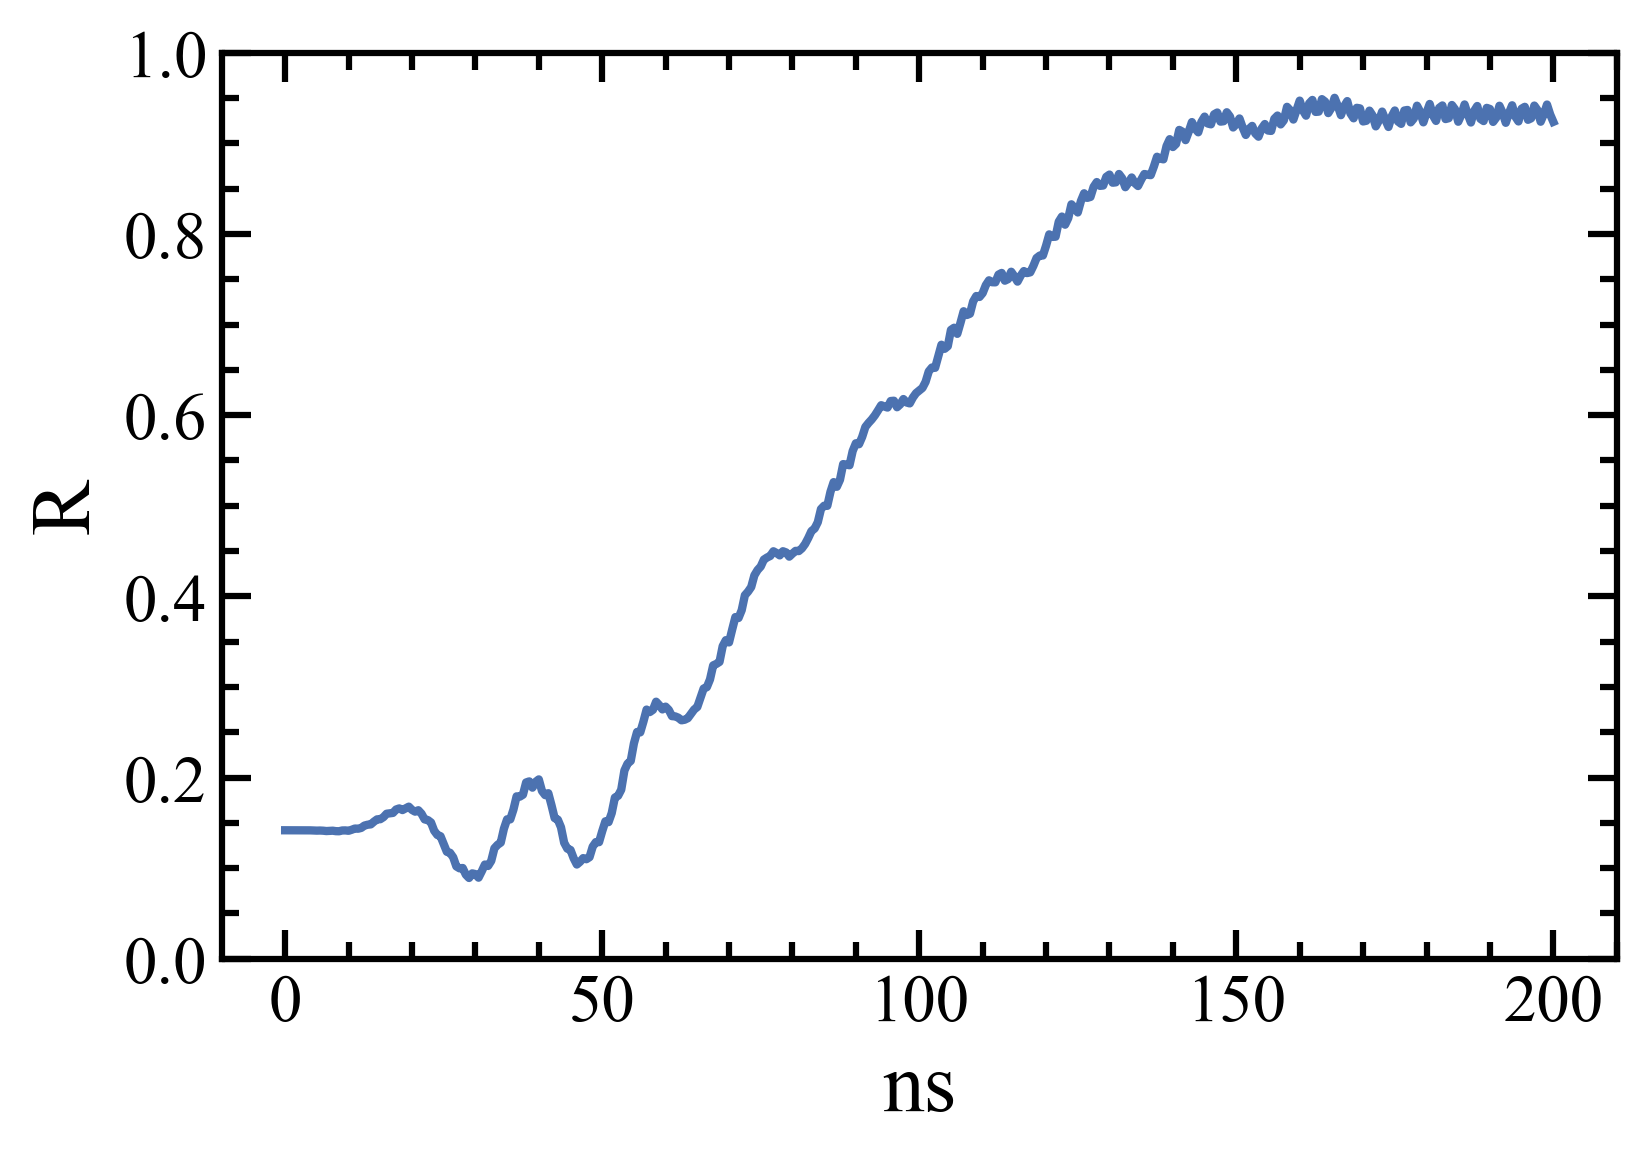

In [52]:
sx0 = expect(IX,U_t*sup_state0)
sy0 = expect(IY,U_t*sup_state0)
sz0 = expect(IZ,U_t*sup_state0)
sx1 = expect(IX,U_t*sup_state1)
sy1 = expect(IY,U_t*sup_state1)
sz1 = expect(IZ,U_t*sup_state1)
R = 0.5*np.sqrt((sx0-sx1)**2 + (sy0-sy1)**2+(sz0-sz1)**2)

plt.plot(t_points, R)
plt.ylabel('R')
plt.xlabel('ns')
plt.ylim([0,1])

# Gate optimization

In [44]:
f_00_01 = abs(system.freq(level1, level3))
f_00_10 = abs(system.freq(level1, level2))
print(f_00_01)
print(f_00_10)

0.26962087738879714
0.23232110419257324


In [59]:
delta_omega_d = 0.05
omega_d = f_00_01 + delta_omega_d
T_gate = 100
T_rise = T_gate/2.0

def infidelity(x):
    drive_amplitude1 = x[0]  # MHz
    drive_amplitude2 = x[1]  # MHz
    drive_amplitude1 = drive_amplitude1*1e-3*2*np.pi
    drive_amplitude2 = drive_amplitude2*1e-3*2*np.pi
    epsilon1 = drive_amplitude1 / abs(matr_el1)
    epsilon2 = drive_amplitude2 / abs(matr_el2)
    H_drive = epsilon1*system.phi(0) + epsilon2*system.phi(1)
    U_t = gates.evolution_operator_microwave_nonorm(system.H(), H_drive, t_points=t_points,T_gate=T_gate, T_rise = T_rise, shape=shape, DRAG = drag, DRAG_coefficient = drag_coeff, omega_d=omega_d,interaction=interaction)
    fidelity = gates.fidelity_cz_gate(
    system, U_t[-1], comp_space=comp_space,
    interaction=interaction)
    return (1.0 - fidelity)

# drive_freq_guess = abs(system.freq(level1, level3)) + 0.05
x0 = [60,40]
xopt = minimize(infidelity, x0, method ='Nelder-Mead', tol = 1e-8)
infidel = infidelity(xopt.x)
print (infidel, xopt.x)

1.3649255944159222e-05 [55.54853112 28.10535826]


In [120]:
print (1-infidel)

0.9758107522417303


In [49]:
E_L_array = np.linspace(0.45,1.4,20)
print (E_L_array)

[0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1
 1.15 1.2  1.25 1.3  1.35 1.4 ]


# Sweep parameters

In [62]:
# E_L_array = np.linspace(0.55,1.6,316)
E_L_array = np.linspace(0.55,1.6,211)
T_gate = 100
T_rise = T_gate/2.0
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

infidelity_array = np.zeros_like(E_L_array)
amplitude1_array = np.zeros_like(E_L_array)
amplitude2_array = np.zeros_like(E_L_array)

E_L1 = 0.5
E_C1 = 1.0
E_J1 = 4

E_C2 = 1.0
E_J2 = 4

nlev_q = 5

J_L = 0.002
J_C = 0.0115
# J_C_array = np.load(figpath+'/optimal_JC.npy')
phi_ext_A = np.pi
phi_ext_B = np.pi

# Pulse shape.
shape = 'cosflattop'  # 'gauss', 'cos' for 1-cos, or 'square'
sigma = 0.25  # sigma in units of T_gate for shape=='gauss'
drag = False
drag_coeff = 0.2
delta_omega_d = 0.05

# Hilbert space.
nlev_q = 5

# Indices of the computational space.
interaction = 'on'
comp_space = ['00', '01', '10', '11']

# Instantiate objects
qubitA = fluxonium.Fluxonium(
    E_L=E_L1, E_C=E_C1, E_J=E_J1, nlev=nlev_q, phi_ext = phi_ext_A)

for idx, E_L2 in enumerate(E_L_array):
    #Define qubit B
    qubitB = fluxonium.Fluxonium(
    E_L=E_L2, E_C=E_C2, E_J=E_J2, nlev=nlev_q, phi_ext = phi_ext_B)
    system = coupobj.CoupledObjects(qubitA, qubitB,
                                    [qubitA, qubitB, J_L, 'flux'],
                                    [qubitA, qubitB, J_C, 'charge'])
    state_00 = system.eigvec('00')
    state_10 = system.eigvec('10')
    state_01 = system.eigvec('01')
    state_11 = system.eigvec('11')   
    
    #Define drive frequency
    transition_to_drive = ('00', '10', '01')
    level1, level2, level3 = transition_to_drive[0], transition_to_drive[1], transition_to_drive[2]
#     omega_d = (abs(system.freq(level1, level3)) + abs(system.freq(level1, level2)))/2.0 + 0.05
    omega_d = abs(system.freq(level1, level3)) + 0.05
    
    #matrix element
    matr_el1 = np.abs(system.phi_ij(qubitA, level1, level2))
    matr_el2 = np.abs(system.phi_ij(qubitB, level1, level3))
    #fidelity optimization
    def infidelity(x):
        drive_amplitude1 = x[0]  # MHz
        drive_amplitude2 = x[1]  # MHz
        drive_amplitude1 = drive_amplitude1*1e-3*2*np.pi
        drive_amplitude2 = drive_amplitude2*1e-3*2*np.pi
        epsilon1 = drive_amplitude1 / abs(matr_el1)
        epsilon2 = drive_amplitude2 / abs(matr_el2)
        H_drive = epsilon1*system.phi(0) + epsilon2*system.phi(1)
        U_t = gates.evolution_operator_microwave_nonorm(system.H(), H_drive, t_points=t_points,T_gate=T_gate,T_rise=T_rise,
                                                        shape=shape, DRAG = drag, DRAG_coefficient = drag_coeff,
                                                        omega_d=omega_d,interaction=interaction)
        fidelity = gates.fidelity_cz_gate(
        system, U_t[-1], comp_space=comp_space,
        interaction=interaction)
        return (1.0 - fidelity)
    if idx == 0:
        coupl_guess1 = -55
        coupl_guess2 = -28
    else: 
        coupl_guess1 = amplitude1_array[idx-1]
        coupl_guess2 = amplitude2_array[idx-1]
#     if (E_L2<1):
#         omega_d_guess = abs(system.freq(level1, level3)) + delta_omega_d
#     else:
#         omega_d_guess = abs(system.freq(level1, level3)) - delta_omega_d
    x0 = [coupl_guess1, coupl_guess2]
    xopt = minimize(infidelity, x0, method ='Nelder-Mead', tol = None)
    amplitude1_array[idx] = xopt.x[0]
    amplitude2_array[idx] = xopt.x[1]
    infidelity_array[idx] = infidelity(xopt.x)
    print (idx)
    print (xopt.x)
    print(infidelity(xopt.x))
    now = datetime.now()
    # dd/mm/YY H:M:S
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    print("date and time =", dt_string)
np.save(figpath+'/CZ_fidelity_vs_detuning_1GHz_100ns_full1.npy',infidelity_array)

0
[-81.37206499 -50.51738423]
0.00014232628936883263
date and time = 30/12/2021 00:09:35
1
[-83.79062518 -51.52160859]
0.00016751131889536364
date and time = 30/12/2021 00:17:21
2
[-98.70451509 -46.49798315]
3.828610730904902e-05
date and time = 30/12/2021 00:26:16
3
[-99.05763103 -48.19790552]
5.280280091723988e-05
date and time = 30/12/2021 00:33:45
4
[-101.43294071  -49.08486106]
6.464594762456422e-05
date and time = 30/12/2021 00:41:11
5
[-116.16823399  -45.57559263]
3.821478211585294e-05
date and time = 30/12/2021 00:49:43
6
[-116.40218615  -47.04116614]
3.6205677248490886e-05
date and time = 30/12/2021 00:56:50
7
[-118.62795092  -47.90604985]
3.8028493343889025e-05
date and time = 30/12/2021 01:03:27
8
[-123.72615091  -47.85650833]
4.171215567350117e-05
date and time = 30/12/2021 01:10:31
9
[-131.04470978  -47.21536455]
3.936932897319334e-05
date and time = 30/12/2021 01:17:11
10
[-133.84598379  -47.89334152]
3.751293402609601e-05
date and time = 30/12/2021 01:23:31
11
[-137.5568

0.0029804688047390115
date and time = 30/12/2021 11:30:43
91
[-704.50891618 -132.05553507]
0.003681471997621366
date and time = 30/12/2021 11:38:47
92
[-708.1547837 -132.5440497]
0.004559654251463763
date and time = 30/12/2021 11:46:54
93
[-712.31997589 -133.05375115]
0.005611414995633668
date and time = 30/12/2021 11:54:51
94
[-716.7805706  -133.60468837]
0.006829175615190253
date and time = 30/12/2021 12:03:02
95
[-721.27680932 -134.24455299]
0.008201710886973634
date and time = 30/12/2021 12:10:43
96
[-733.86504346 -153.61218685]
0.005888748869025684
date and time = 30/12/2021 12:20:11
97
[-738.03083488 -153.80738611]
0.00692141219847886
date and time = 30/12/2021 12:29:20
98
[-742.42529077 -153.99674796]
0.008131981776630326
date and time = 30/12/2021 12:38:32
99
[-746.96067364 -154.18208351]
0.009514164031351191
date and time = 30/12/2021 12:46:28
100
[-751.59311915 -154.36501429]
0.011061675541747973
date and time = 30/12/2021 12:54:20
101
[-756.28861721 -154.54727641]
0.01276830

0.2685479017798571
date and time = 31/12/2021 01:25:53
182
[-1213.01262779  -317.20875444]
0.2719142137965347
date and time = 31/12/2021 01:34:51
183
[-1229.02234457  -317.17198032]
0.27516303713393475
date and time = 31/12/2021 01:43:59
184
[-1255.24613819  -317.16304828]
0.2777349516894432
date and time = 31/12/2021 01:52:57
185
[-1240.91225181  -317.00562543]
0.2805693122862468
date and time = 31/12/2021 02:01:53
186
[-1268.58119035  -316.94670715]
0.2834548177193472
date and time = 31/12/2021 02:10:32
187
[-1281.49665633  -316.87314588]
0.2858267720749065
date and time = 31/12/2021 02:18:21
188
[-1325.73874401  -316.84930938]
0.2879490573621929
date and time = 31/12/2021 02:26:54
189
[-1612.72145672  -316.63597023]
0.28604076416427104
date and time = 31/12/2021 02:37:08
190
[-1705.4932851   -316.41525448]
0.26833537006615793
date and time = 31/12/2021 02:46:04
191
[-1773.59563232  -316.19164539]
0.24323494083019503
date and time = 31/12/2021 02:54:23
192
[-1830.50607143  -316.03968

In [87]:
np.save(figpath+'/CZ_fidelity_vs_detuning_1GHz_100ns_full1.npy', infidelity_array)
np.save(figpath+'/CZ_fidelity_vs_detuning_1GHz_100ns_full_amp1.npy', amplitude1_array)
np.save(figpath+'/CZ_fidelity_vs_detuning_1GHz_100ns_full_amp2.npy', amplitude2_array)

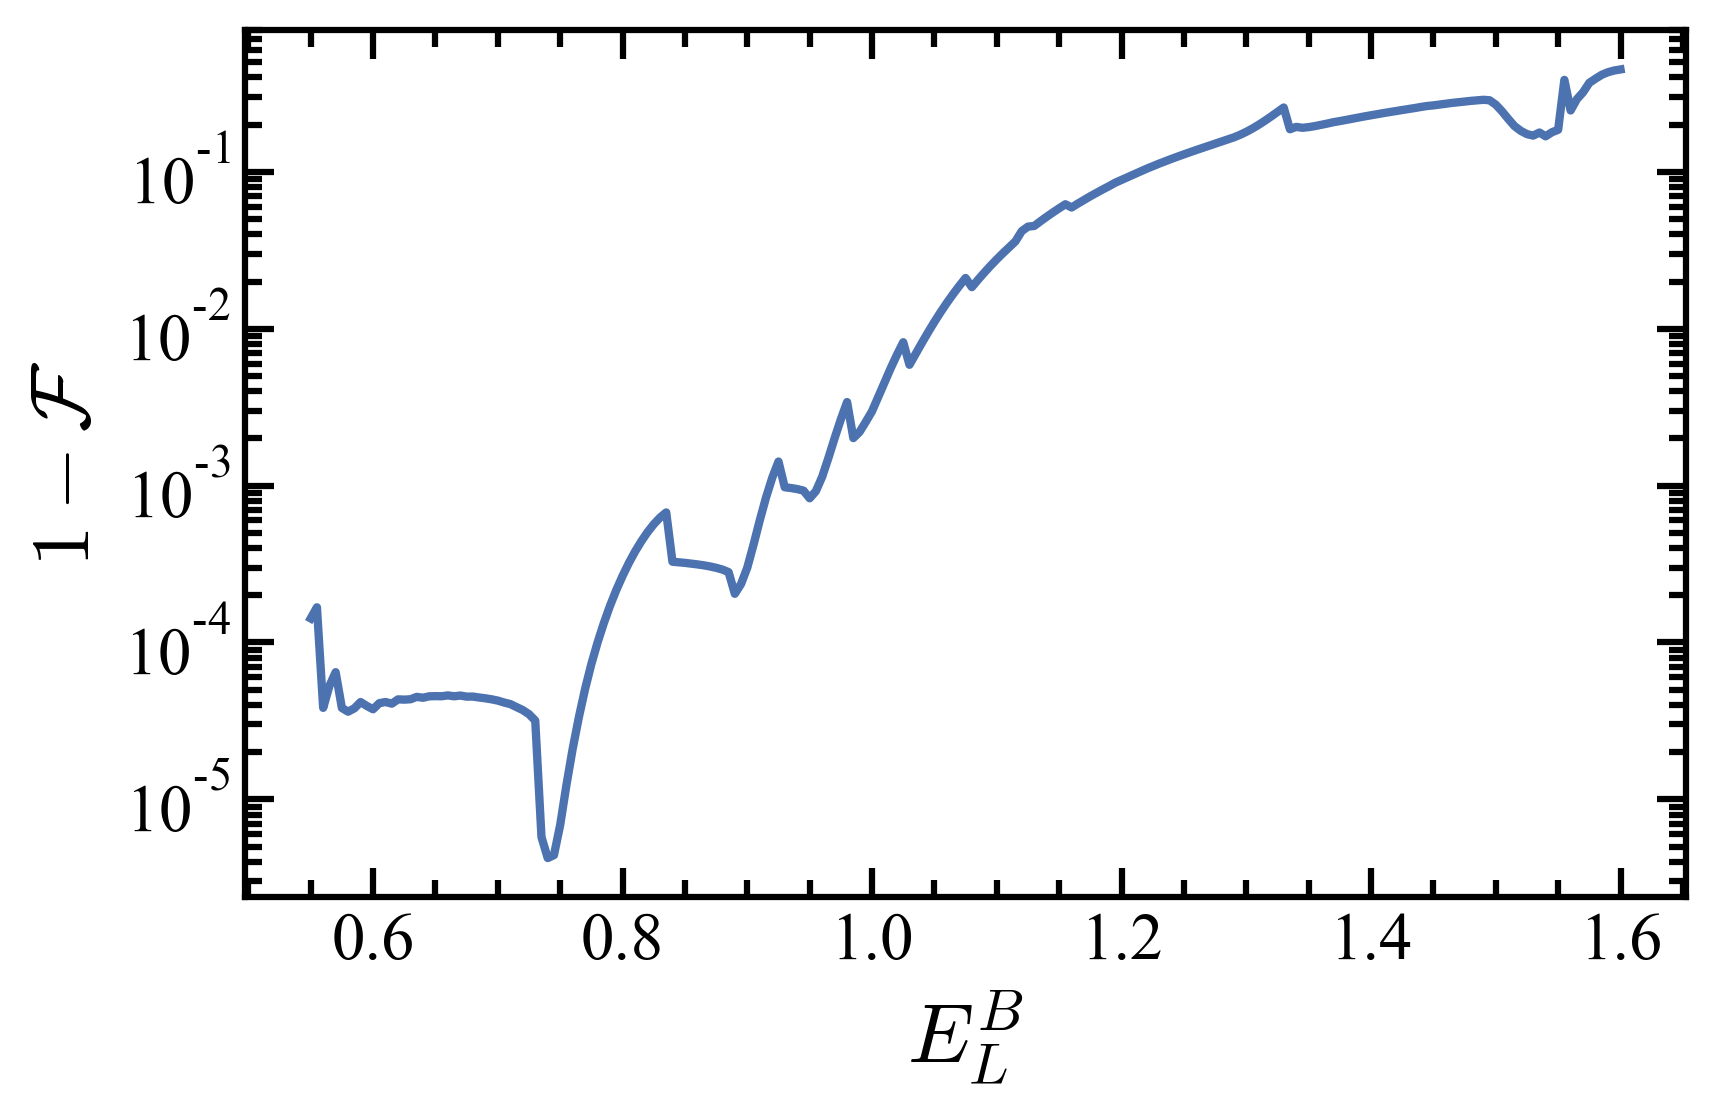

In [63]:
plt.plot(E_L_array, infidelity_array)
plt.yscale('log')
# plt.ylim([1e-7,1e-4])
# plt.yticks([1e-8,1e-6,1e-4,1e-2])
plt.ylabel(r'$1-\mathcal{F}$')
plt.xlabel(r'$E_L^B$')
plt.tight_layout()

# Check leakage

In [165]:
amplitude1_array = np.load (figpath+'/CZ_fidelity_vs_detuning_1GHz_200ns_full_amp1.npy')
amplitude2_array = np.load (figpath+'/CZ_fidelity_vs_detuning_1GHz_200ns_full_amp2.npy')
leakage = np.zeros_like(amplitude1_array)
leakage1 = np.zeros_like(amplitude1_array)
leakage2 = np.zeros_like(amplitude1_array)

In [166]:
E_L_array = np.linspace(0.55,1.6,211)
T_gate = 200
T_rise = T_gate/3.0
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

E_L1 = 0.5
E_C1 = 1.0
E_J1 = 4

E_C2 = 1.0
E_J2 = 4

nlev_q = 5

J_L = 0.002
J_C = 0.0115
# J_C_array = np.load(figpath+'/optimal_JC.npy')
phi_ext_A = np.pi
phi_ext_B = np.pi

# Pulse shape.
shape = 'cosflattop'  # 'gauss', 'cos' for 1-cos, or 'square'
sigma = 0.25  # sigma in units of T_gate for shape=='gauss'
drag = False
drag_coeff = 0.2
delta_omega_d = 0.05

# Hilbert space.
nlev_q = 5

# Indices of the computational space.
interaction = 'on'
comp_space = ['00', '01', '10', '11']

# Instantiate objects
qubitA = fluxonium.Fluxonium(
    E_L=E_L1, E_C=E_C1, E_J=E_J1, nlev=nlev_q, phi_ext = phi_ext_A)

for idx, E_L2 in enumerate(E_L_array):
    #Define qubit B
    qubitB = fluxonium.Fluxonium(
    E_L=E_L2, E_C=E_C2, E_J=E_J2, nlev=nlev_q, phi_ext = phi_ext_B)
    system = coupobj.CoupledObjects(qubitA, qubitB,
                                    [qubitA, qubitB, J_L, 'flux'],
                                    [qubitA, qubitB, J_C, 'charge'])
    state_00 = system.eigvec('00')
    state_10 = system.eigvec('10')
    state_01 = system.eigvec('01')
    state_11 = system.eigvec('11')   
    
    #Define drive frequency
    transition_to_drive = ('00', '10', '01')
    level1, level2, level3 = transition_to_drive[0], transition_to_drive[1], transition_to_drive[2]
#     omega_d = (abs(system.freq(level1, level3)) + abs(system.freq(level1, level2)))/2.0 + 0.05
    omega_d = abs(system.freq(level1, level3)) + 0.05
    
    #matrix element
    matr_el1 = np.abs(system.phi_ij(qubitA, level1, level2))
    matr_el2 = np.abs(system.phi_ij(qubitB, level1, level3))
    #fidelity optimization
    def leakage_func(x):
        drive_amplitude1 = x[0]  # MHz
        drive_amplitude2 = x[1]  # MHz
        drive_amplitude1 = drive_amplitude1*1e-3*2*np.pi
        drive_amplitude2 = drive_amplitude2*1e-3*2*np.pi
        epsilon1 = drive_amplitude1 / abs(matr_el1)
        epsilon2 = drive_amplitude2 / abs(matr_el2)
        H_drive = epsilon1*system.phi(0) + epsilon2*system.phi(1)
        U_t = gates.evolution_operator_microwave_nonorm(system.H(), H_drive, t_points=t_points,T_gate=T_gate,T_rise=T_rise,
                                                        shape=shape, DRAG = drag, DRAG_coefficient = drag_coeff,
                                                        omega_d=omega_d,interaction=interaction)
        P_00 = gates.prob_transition(U_t[-1],state_00,state_00)# + gates.prob_transition(U_t[-1],state_00,state_01)\
        #+ gates.prob_transition(U_t[-1],state_00,state_10) + gates.prob_transition(U_t[-1],state_00,state_11)
        P_01 = gates.prob_transition(U_t[-1],state_01,state_00)# + gates.prob_transition(U_t[-1],state_01,state_01)\
        #+ gates.prob_transition(U_t[-1],state_01,state_10) + gates.prob_transition(U_t[-1],state_01,state_11)
        P_10 = gates.prob_transition(U_t[-1],state_10,state_00)# + gates.prob_transition(U_t[-1],state_10,state_01)\
        #+ gates.prob_transition(U_t[-1],state_10,state_10) + gates.prob_transition(U_t[-1],state_10,state_11)
        P_11 = gates.prob_transition(U_t[-1],state_11,state_00)# + gates.prob_transition(U_t[-1],state_11,state_01)\
        #+ gates.prob_transition(U_t[-1],state_11,state_10) + gates.prob_transition(U_t[-1],state_11,state_11)
        
        return (1.0 - P_00 -P_01-P_10-P_11)
    x = [amplitude1_array[idx], amplitude2_array[idx]]
    leakage[idx] = leakage_func(x)   
#     print (idx)
#     now = datetime.now()
    # dd/mm/YY H:M:S
#     dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
#     print("date and time =", dt_string)
#     print (leakage[idx])
    

In [167]:
E_L_array = np.linspace(0.55,1.6,211)
T_gate = 200
T_rise = T_gate/3.0
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

E_L1 = 0.5
E_C1 = 1.0
E_J1 = 4

E_C2 = 1.0
E_J2 = 4

nlev_q = 5

J_L = 0.002
J_C = 0.0115
# J_C_array = np.load(figpath+'/optimal_JC.npy')
phi_ext_A = np.pi
phi_ext_B = np.pi

# Pulse shape.
shape = 'cosflattop'  # 'gauss', 'cos' for 1-cos, or 'square'
sigma = 0.25  # sigma in units of T_gate for shape=='gauss'
drag = False
drag_coeff = 0.2
delta_omega_d = 0.05

# Hilbert space.
nlev_q = 5

# Indices of the computational space.
interaction = 'on'
comp_space = ['00', '01', '10', '11']

# Instantiate objects
qubitA = fluxonium.Fluxonium(
    E_L=E_L1, E_C=E_C1, E_J=E_J1, nlev=nlev_q, phi_ext = phi_ext_A)

for idx, E_L2 in enumerate(E_L_array):
    #Define qubit B
    qubitB = fluxonium.Fluxonium(
    E_L=E_L2, E_C=E_C2, E_J=E_J2, nlev=nlev_q, phi_ext = phi_ext_B)
    system = coupobj.CoupledObjects(qubitA, qubitB,
                                    [qubitA, qubitB, J_L, 'flux'],
                                    [qubitA, qubitB, J_C, 'charge'])
    state_00 = system.eigvec('00')
    state_10 = system.eigvec('10')
    state_01 = system.eigvec('01')
    state_11 = system.eigvec('11')   
    
    #Define drive frequency
    transition_to_drive = ('00', '10', '01')
    level1, level2, level3 = transition_to_drive[0], transition_to_drive[1], transition_to_drive[2]
#     omega_d = (abs(system.freq(level1, level3)) + abs(system.freq(level1, level2)))/2.0 + 0.05
    omega_d = abs(system.freq(level1, level3)) + 0.05
    
    #matrix element
    matr_el1 = np.abs(system.phi_ij(qubitA, level1, level2))
    matr_el2 = np.abs(system.phi_ij(qubitB, level1, level3))
    #fidelity optimization
    def leakage_func(x):
        drive_amplitude1 = x[0]  # MHz
        drive_amplitude2 = x[1]  # MHz
        drive_amplitude1 = drive_amplitude1*1e-3*2*np.pi
        drive_amplitude2 = drive_amplitude2*1e-3*2*np.pi
        epsilon1 = drive_amplitude1 / abs(matr_el1)
        epsilon2 = drive_amplitude2 / abs(matr_el2)
        H_drive = epsilon1*system.phi(0)
        U_t = gates.evolution_operator_microwave_nonorm(system.H(), H_drive, t_points=t_points,T_gate=T_gate,T_rise=T_rise,
                                                        shape=shape, DRAG = drag, DRAG_coefficient = drag_coeff,
                                                        omega_d=omega_d,interaction=interaction)
        P_00 = gates.prob_transition(U_t[-1],state_00,state_00)# + gates.prob_transition(U_t[-1],state_00,state_01)\
        #+ gates.prob_transition(U_t[-1],state_00,state_10) + gates.prob_transition(U_t[-1],state_00,state_11)
        P_01 = gates.prob_transition(U_t[-1],state_01,state_00)# + gates.prob_transition(U_t[-1],state_01,state_01)\
        #+ gates.prob_transition(U_t[-1],state_01,state_10) + gates.prob_transition(U_t[-1],state_01,state_11)
        P_10 = gates.prob_transition(U_t[-1],state_10,state_00)# + gates.prob_transition(U_t[-1],state_10,state_01)\
        #+ gates.prob_transition(U_t[-1],state_10,state_10) + gates.prob_transition(U_t[-1],state_10,state_11)
        P_11 = gates.prob_transition(U_t[-1],state_11,state_00)# + gates.prob_transition(U_t[-1],state_11,state_01)\
        #+ gates.prob_transition(U_t[-1],state_11,state_10) + gates.prob_transition(U_t[-1],state_11,state_11)
        
        return (1.0 -P_00 -P_01-P_10-P_11)
    x = [amplitude1_array[idx], amplitude2_array[idx]]
    leakage1[idx] = leakage_func(x)   
#     print (idx)
#     now = datetime.now()
#     # dd/mm/YY H:M:S
#     dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
#     print("date and time =", dt_string)
#     print (leakage[idx])

In [168]:
E_L_array = np.linspace(0.55,1.6,211)
T_gate = 200
T_rise = T_gate/3.0
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

E_L1 = 0.5
E_C1 = 1.0
E_J1 = 4

E_C2 = 1.0
E_J2 = 4

nlev_q = 5

J_L = 0.002
J_C = 0.0115
# J_C_array = np.load(figpath+'/optimal_JC.npy')
phi_ext_A = np.pi
phi_ext_B = np.pi

# Pulse shape.
shape = 'cosflattop'  # 'gauss', 'cos' for 1-cos, or 'square'
sigma = 0.25  # sigma in units of T_gate for shape=='gauss'
drag = False
drag_coeff = 0.2
delta_omega_d = 0.05

# Hilbert space.
nlev_q = 5

# Indices of the computational space.
interaction = 'on'
comp_space = ['00', '01', '10', '11']

# Instantiate objects
qubitA = fluxonium.Fluxonium(
    E_L=E_L1, E_C=E_C1, E_J=E_J1, nlev=nlev_q, phi_ext = phi_ext_A)

for idx, E_L2 in enumerate(E_L_array):
    #Define qubit B
    qubitB = fluxonium.Fluxonium(
    E_L=E_L2, E_C=E_C2, E_J=E_J2, nlev=nlev_q, phi_ext = phi_ext_B)
    system = coupobj.CoupledObjects(qubitA, qubitB,
                                    [qubitA, qubitB, J_L, 'flux'],
                                    [qubitA, qubitB, J_C, 'charge'])
    state_00 = system.eigvec('00')
    state_10 = system.eigvec('10')
    state_01 = system.eigvec('01')
    state_11 = system.eigvec('11')   
    
    #Define drive frequency
    transition_to_drive = ('00', '10', '01')
    level1, level2, level3 = transition_to_drive[0], transition_to_drive[1], transition_to_drive[2]
#     omega_d = (abs(system.freq(level1, level3)) + abs(system.freq(level1, level2)))/2.0 + 0.05
    omega_d = abs(system.freq(level1, level3)) + 0.05
    
    #matrix element
    matr_el1 = np.abs(system.phi_ij(qubitA, level1, level2))
    matr_el2 = np.abs(system.phi_ij(qubitB, level1, level3))
    #fidelity optimization
    def leakage_func(x):
        drive_amplitude1 = x[0]  # MHz
        drive_amplitude2 = x[1]  # MHz
        drive_amplitude1 = drive_amplitude1*1e-3*2*np.pi
        drive_amplitude2 = drive_amplitude2*1e-3*2*np.pi
        epsilon1 = drive_amplitude1 / abs(matr_el1)
        epsilon2 = drive_amplitude2 / abs(matr_el2)
        H_drive = epsilon2*system.phi(1)
        U_t = gates.evolution_operator_microwave_nonorm(system.H(), H_drive, t_points=t_points,T_gate=T_gate,T_rise=T_rise,
                                                        shape=shape, DRAG = drag, DRAG_coefficient = drag_coeff,
                                                        omega_d=omega_d,interaction=interaction)
        P_00 = gates.prob_transition(U_t[-1],state_00,state_00)# + gates.prob_transition(U_t[-1],state_00,state_01)\
        #+ gates.prob_transition(U_t[-1],state_00,state_10) + gates.prob_transition(U_t[-1],state_00,state_11)
        P_01 = gates.prob_transition(U_t[-1],state_01,state_00)# + gates.prob_transition(U_t[-1],state_01,state_01)\
        #+ gates.prob_transition(U_t[-1],state_01,state_10) + gates.prob_transition(U_t[-1],state_01,state_11)
        P_10 = gates.prob_transition(U_t[-1],state_10,state_00)# + gates.prob_transition(U_t[-1],state_10,state_01)\
        #+ gates.prob_transition(U_t[-1],state_10,state_10) + gates.prob_transition(U_t[-1],state_10,state_11)
        P_11 = gates.prob_transition(U_t[-1],state_11,state_00)# + gates.prob_transition(U_t[-1],state_11,state_01)\
        #+ gates.prob_transition(U_t[-1],state_11,state_10) + gates.prob_transition(U_t[-1],state_11,state_11)
        
        return (1.0 - P_00 -P_01-P_10-P_11)
    x = [amplitude1_array[idx], amplitude2_array[idx]]
    leakage2[idx] = leakage_func(x)  

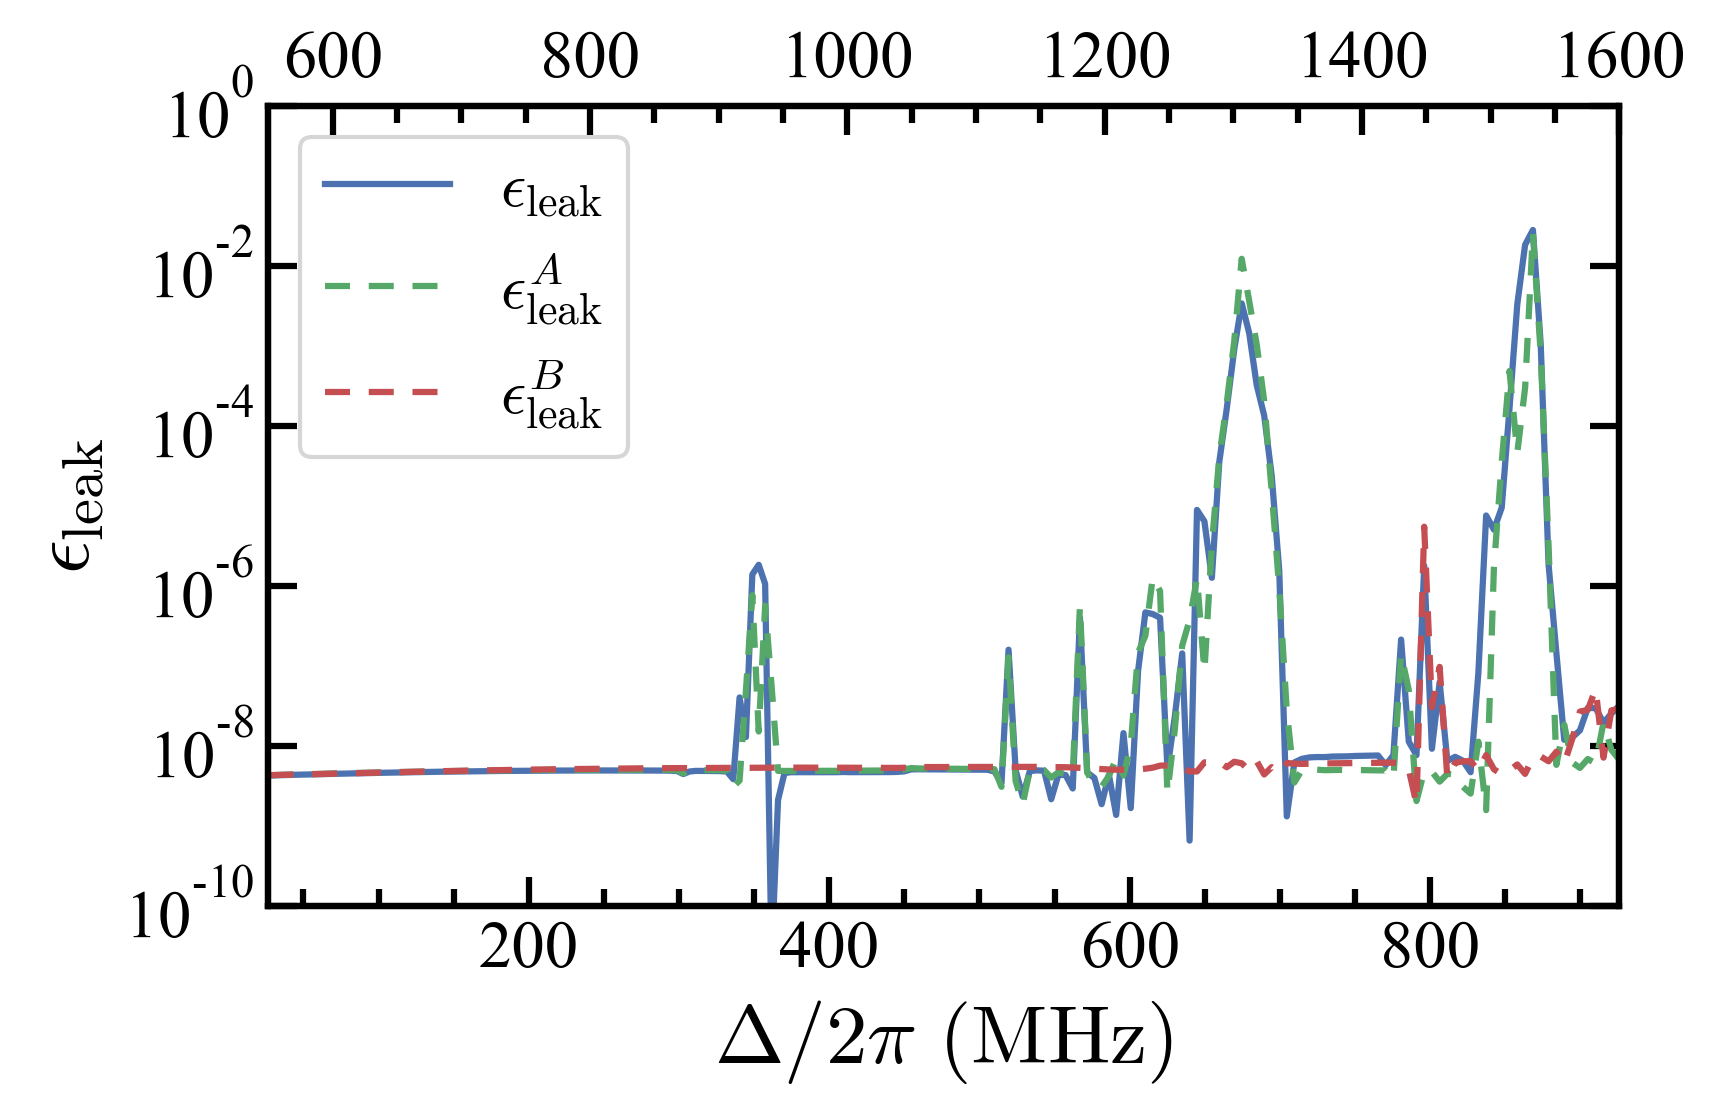

In [10]:
leakage = np.load(figpath+'/CZ_leakage.npy')
leakage1 = np.load(figpath+'/CZ_leakage1.npy')
leakage2 = np.load(figpath+'/CZ_leakage2.npy')

fig,axes=plt.subplots(figsize = [6,4])
twin_axes = axes.twiny()
axes.plot(detuning1*1e3, abs(leakage),label = r'$\epsilon_\mathrm{leak}$', linewidth = 1.5)
axes.plot(detuning1*1e3, abs(leakage1),label = r'$\epsilon_\mathrm{leak}^A$', linestyle='--', linewidth = 1.5, color = 'C1')
axes.plot(detuning1*1e3, abs(leakage2), color = 'C2',label = r'$\epsilon_\mathrm{leak}^B$', linewidth = 1.5, linestyle='--')
axes.set_xlim([detuning1[0]*1e3, detuning1[-1]*1e3])
axes.set_ylim([1e-10,1])

axes.set_yscale('log')
axes.set_ylabel(r'$\epsilon_\mathrm{leak}$')
axes.set_xlabel(r'$\Delta/2\pi~(\mathrm{MHz})$')
axes.legend()

twin_axes.set_xlim([E_L_array[0]*1e3, E_L_array[-1]*1e3])
twin_axes.set_ylim([1e-10,1])
# twin_axes.legend()
# twin_axes.set_xlabel(r'$E_L^B~\mathrm{MHz}$')
fig.tight_layout()
figname = 'CZ_leakage.pdf'
plt.savefig(figpath+figname)

In [196]:
np.save(figpath+'/CZ_leakage.npy', leakage)
np.save(figpath+'/CZ_leakage1.npy', leakage1)
np.save(figpath+'/CZ_leakage2.npy', leakage2)

In [157]:
E_L_array = np.linspace(0.55,1.6,211)
leakageA = np.zeros_like(E_L_array)
T_gate = 200
T_rise = T_gate/3.0
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

E_L1 = 0.5
E_C1 = 1.0
E_J1 = 4

E_C2 = 1.0
E_J2 = 4

nlev_q = 5

J_L = 0.002
J_C = 0.0115
# J_C_array = np.load(figpath+'/optimal_JC.npy')
phi_ext_A = np.pi
phi_ext_B = np.pi

# Pulse shape.
shape = 'cosflattop'  # 'gauss', 'cos' for 1-cos, or 'square'
sigma = 0.25  # sigma in units of T_gate for shape=='gauss'
drag = False
drag_coeff = 0.2
delta_omega_d = 0.05

# Hilbert space.
nlev_q = 5

# Indices of the computational space.
interaction = 'on'
comp_space = ['00', '01', '10', '11']

# Instantiate objects
qubitA = fluxonium.Fluxonium(
    E_L=E_L1, E_C=E_C1, E_J=E_J1, nlev=nlev_q, phi_ext = phi_ext_A)
state_0 = basis(nlev_q,0)
state_1 = basis(nlev_q,0)
for idx, E_L2 in enumerate(E_L_array):
    #Define qubit B
    qubitB = fluxonium.Fluxonium(
    E_L=E_L2, E_C=E_C2, E_J=E_J2, nlev=nlev_q, phi_ext = phi_ext_B)
    
    #Define drive frequency
    omega_d = abs(qubitB.freq(0, 1)) + 0.05
    
    #matrix element
    matr_el1 = np.abs(qubitA.phi_ij(0,1))
    matr_el2 = np.abs(qubitB.phi_ij(0,1))
    #fidelity optimization
    def leakage_func(x):
        drive_amplitude1 = x[0]  # MHz
        drive_amplitude2 = x[1]  # MHz
        drive_amplitude1 = drive_amplitude1*1e-3*2*np.pi
        drive_amplitude2 = drive_amplitude2*1e-3*2*np.pi
        epsilon1 = drive_amplitude1 / abs(matr_el1)
        epsilon2 = drive_amplitude2 / abs(matr_el2)
        H_drive = epsilon1*qubitA.phi()
        U_t = gates.evolution_operator_microwave_nonorm(qubitA.H(), H_drive, t_points=t_points,T_gate=T_gate,T_rise=T_rise,
                                                        shape=shape, DRAG = drag, DRAG_coefficient = drag_coeff,
                                                        omega_d=omega_d)
        P_0 = gates.prob_transition(U_t[-1],state_0,state_0)
        P_1 = gates.prob_transition(U_t[-1],state_1,state_0)
        return (1.0-P_0-P_1)
    x = [amplitude1_array[idx], amplitude2_array[idx]]
    leakageA[idx] = leakage_func(x)  
#     print (leakageA[idx])

-0.9999999910858728
-0.9999925704484038
-0.999998121310109
-0.9999851728443747
-0.9999890560285412
-0.9999966425104425
-0.9999996827507258
-0.9999985874767019
-0.9999870670206752
-0.9999991499981218
-0.9999974787876102
-0.9999993114478489
-0.9999960835753103
-0.999992078732199
-0.9999992257465249
-0.9999993419031361
-0.9999993487844678
-0.999994931017594
-0.9999988839998957
-0.9999980191279452
-0.9999999101578398
-0.9999993403897294
-0.9999976100011954
-0.9999984716611008
-0.9999999235448787
-0.9999999940916835
-0.9999978831313772
-0.9999994207724894
-0.9999996972519039
-0.9999999253607996
-0.9999986273366752
-0.9999996830504174
-0.9999996590505429
-0.9999999327143245
-0.9999991472750274
-0.9999994752986554
-0.9999998377903121
-0.9999999542836648
-0.9999995302493683
-0.9999990061706678
-0.9999999990958521
-0.9999999999339695
-0.9999998884441368
-0.9999991213300579
-0.9999998808205051
-0.9999999234447128
-0.9999998943600736
-0.9999998924007703
-0.9999998156457623
-0.999999933152026
-0.9

In [ ]:
E_L_array = np.linspace(0.55,1.6,211)
leakageA = np.zeros_like(E_L_array)
T_gate = 200
T_rise = T_gate/3.0
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

E_L1 = 0.5
E_C1 = 1.0
E_J1 = 4

E_C2 = 1.0
E_J2 = 4

nlev_q = 5

J_L = 0.002
J_C = 0.0115
# J_C_array = np.load(figpath+'/optimal_JC.npy')
phi_ext_A = np.pi
phi_ext_B = np.pi

# Pulse shape.
shape = 'cosflattop'  # 'gauss', 'cos' for 1-cos, or 'square'
sigma = 0.25  # sigma in units of T_gate for shape=='gauss'
drag = False
drag_coeff = 0.2
delta_omega_d = 0.05

# Hilbert space.
nlev_q = 5

# Indices of the computational space.
interaction = 'on'
comp_space = ['00', '01', '10', '11']

# Instantiate objects
qubitA = fluxonium.Fluxonium(
    E_L=E_L1, E_C=E_C1, E_J=E_J1, nlev=nlev_q, phi_ext = phi_ext_A)
state_0 = qubitA.eigvec(0)
state_1 = qubitA.eigvec(1)
for idx, E_L2 in enumerate(E_L_array):
    #Define qubit B
    qubitB = fluxonium.Fluxonium(
    E_L=E_L2, E_C=E_C2, E_J=E_J2, nlev=nlev_q, phi_ext = phi_ext_B)
    
    #Define drive frequency
    omega_d = abs(qubitB.freq(0, 1)) + 0.05
    
    #matrix element
    matr_el1 = np.abs(qubitA.phi_ij(0,1))
    matr_el2 = np.abs(qubitB.phi_ij(0,1))
    #fidelity optimization
    def leakage_func(x):
        drive_amplitude1 = x[0]  # MHz
        drive_amplitude2 = x[1]  # MHz
        drive_amplitude1 = drive_amplitude1*1e-3*2*np.pi
        drive_amplitude2 = drive_amplitude2*1e-3*2*np.pi
        epsilon1 = drive_amplitude1 / abs(matr_el1)
        epsilon2 = drive_amplitude2 / abs(matr_el2)
        H_drive = epsilon1*qubitA.phi()
        U_t = gates.evolution_operator_microwave_nonorm(qubitA.H(), H_drive, t_points=t_points,T_gate=T_gate,T_rise=T_rise,
                                                        shape=shape, DRAG = drag, DRAG_coefficient = drag_coeff,
                                                        omega_d=omega_d)
        P_0 = 0.5*expect(state_0*state_0.dag(),U_t[-1]*state_0)+0.5*expect(state_0*state_0.dag(),U_t[-1]*state_1)# + expect(state_00*state_00.dag(),U_t[-1]*state_01) + expect(state_00*state_00.dag(),U_t[-1]*state_10) + expect(state_00*state_00.dag(),U_t[-1]*state_11)
        P_1 = 0.5*expect(state_1*state_1.dag(),U_t[-1]*state_0)+0.5*expect(state_1*state_1.dag(),U_t[-1]*state_1)# + expect(state_01*state_01.dag(),U_t[-1]*state_01) + expect(state_01*state_01.dag(),U_t[-1]*state_10) + expect(state_01*state_01.dag(),U_t[-1]*state_11)
        
        return (1.0-P_0-P_1)
    x = [amplitude1_array[idx], amplitude2_array[idx]]
    leakageA[idx] = leakage_func(x)  
    print (leakageA[idx])

# Plot for paper

In [5]:
#First, compute detuning from EL
E_L = 0.5
E_C = 1.0
E_J = 4
phi_ext = np.pi
nlev_q=5

#Qubit A
qubit = fluxonium.Fluxonium(
    E_L=E_L, E_C=E_C, E_J=E_J, nlev=nlev_q, phi_ext = phi_ext)
w1 = qubit.freq(0,1)

#Qubit B
E_L_array = np.linspace(0.55,1.6,211)
w2_array = np.zeros_like(E_L_array)
for idx, E_L in enumerate(E_L_array):
    qubit = fluxonium.Fluxonium(
    E_L=E_L, E_C=E_C, E_J=E_J, nlev=nlev_q, phi_ext = phi_ext)
    w2_array[idx] = qubit.freq(0,1)
detuning1 = w2_array-w1

#Qubit B
E_L_array = np.linspace(0.55,1.6,316)
w2_array = np.zeros_like(E_L_array)
for idx, E_L in enumerate(E_L_array):
    qubit = fluxonium.Fluxonium(
    E_L=E_L, E_C=E_C, E_J=E_J, nlev=nlev_q, phi_ext = phi_ext)
    w2_array[idx] = qubit.freq(0,1)
detuning = w2_array-w1

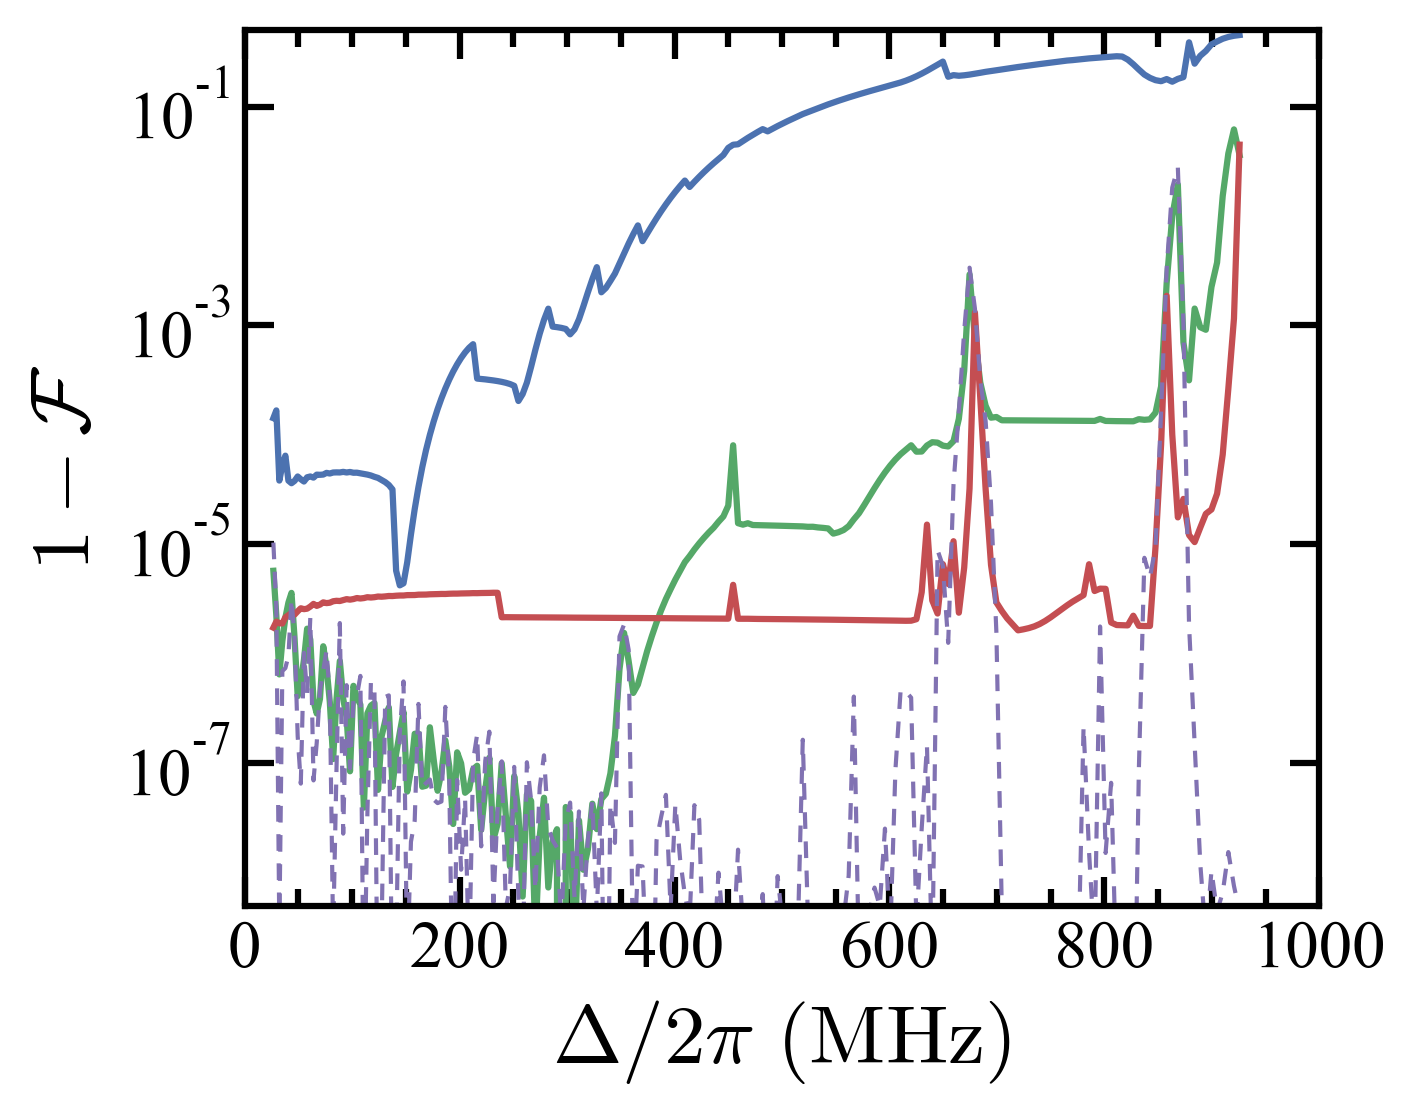

In [119]:
plt.figure(figsize = [5,4])

#100ns gate time
infidelity = np.load(figpath+'/CZ_fidelity_vs_detuning_1GHz_100ns_full1.npy')
plt.plot(detuning1*1e3,infidelity, linewidth = 1.5, label = r'$\tau_g=100~\mathrm{ns}$')
plt.yscale('log')

#200ns gate time
infidelity = np.load(figpath+'/CZ_fidelity_vs_detuning_1GHz_200ns_full.npy')
plt.plot(detuning1*1e3,infidelity, linewidth = 1.5, label = r'$\tau_g=200~\mathrm{ns}$')
plt.yscale('log')

# infidelity = np.load(figpath+'/CZ_fidelity_vs_detuning_1GHz_200ns_full1.npy')
# plt.plot(detuning1*1e3,infidelity, linewidth = 1.5, label = r'$\tau_g=200~\mathrm{ns}$',linestyle = '--')
# plt.yscale('log')

# #300ns gate time
infidelity = np.load(figpath+'/CZ_fidelity_vs_detuning_1GHz_300ns_full1.npy')
plt.plot(detuning1*1e3,infidelity, linewidth = 1.5, label = r'$\tau_g=300~\mathrm{ns}$')
plt.yscale('log')

plt.plot(detuning1*1e3, abs(leakage), linewidth = 1, label = r'$\tau_g=300~\mathrm{ns}$',linestyle = '--')
plt.yscale('log')

# #Plotting format
plt.xlabel(r"$\Delta/2\pi~\mathrm{(MHz)}$")
plt.ylabel(r'$1-\mathcal{F}$')
plt.xlim([0,1000])
plt.ylim([5e-9,5e-1])
# plt.legend()
plt.tight_layout()
# figname = 'CZ_extended.pdf'
# plt.savefig(figpath+figname)